In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { margin-left: 0 !important; width:100% !important; }</style>"))

In [2]:
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import json
from types import SimpleNamespace
import cmath
import glob
import itertools
import tensorboard
import time
import traceback

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
tf.keras.mixed_precision.set_global_policy('float64')

In [4]:
# example0:
# {
#   "EntryType":"EquivalentLoudnessMeasurement",
#   "Calibration":{
#     "HeadphoneFrequencyResponseHash":"eab807a5050b0087109ac1fd6fecbd09197a3dcd",
#     "FullScaleSineDBSPL":100
#   },
#   "Run":{
#     "ID":"1599737802659_2857050667"
#   },
#   "Evaluation":{
#     "ID":"1599738237070_2365796582",
#     "Frequency":697.9866246810275,
#     "Probe":{
#       "Type":"Noise",
#       "Params":{
#         "Level":-10,
#         "LowerLimit":966.84025,
#         "Onset":{
#           "Delay":0,
#           "Duration":0.1
#         },
#         "UpperLimit":1033.15975
#       }
#     },
#     "Combined":{
#       "Type":"Superposition",
#       "Params":[
#         {
#           "Params":{
#             "Level":-40,
#             "LowerLimit":966.84025,
#             "Onset":{
#               "Delay":0.5,
#               "Duration":0.1
#             },
#             "UpperLimit":1033.15975
#           },
#           "Type":"Noise"
#         },{
#           "Params":{
#             "Level":-20,
#             "LowerLimit":672.9766301106662,
#             "Onset":{
#               "Delay":0,
#               "Duration":0.1
#             },
#             "UpperLimit":722.9966192513888
#           },
#           "Type":"Noise"
#         }
#       ]
#     }
#   },
#   "Results":{
#     "ProbeGainForEquivalentLoudness":0.003107877399956887,
#     "ProbeDBSPLForEquivalentLoudness":39.84927756697657
#   }
# }
def experiment_result_to_example(exp, car_fs_sine_db_spl=100, window_size=2048, sample_rate=48000, noise_floor_db_spl=30):
    if exp.EntryType != 'EquivalentLoudnessMeasurement':
        return None
    assert exp.Evaluation.Probe.Type == 'Noise'
    assert exp.Evaluation.Combined.Type == 'Superposition'
    for part in exp.Evaluation.Combined.Params:
        assert part.Type == 'Noise'
        # If this part isn't the probe.
        if (part.Params.LowerLimit != exp.Evaluation.Probe.Params.LowerLimit or
            part.Params.UpperLimit != exp.Evaluation.Probe.Params.UpperLimit):
            # We want to ignore evaluations where probe and masker overlap.
            if ((part.Params.LowerLimit >= exp.Evaluation.Probe.Params.LowerLimit and
                 part.Params.LowerLimit <= exp.Evaluation.Probe.Params.UpperLimit) or
                (part.Params.UpperLimit >= exp.Evaluation.Probe.Params.LowerLimit and
                 part.Params.UpperLimit <= exp.Evaluation.Probe.Params.UpperLimit) or
                (part.Params.LowerLimit <= exp.Evaluation.Probe.Params.LowerLimit and
                 part.Params.UpperLimit >= exp.Evaluation.Probe.Params.UpperLimit)):
                return None
    assert exp.Results.ProbeGainForEquivalentLoudness > 0
    assert exp.Results.ProbeDBSPLForEquivalentLoudness != None
    assert exp.Calibration.FullScaleSineDBSPL > 0

    bin_width = sample_rate / window_size
    def add_noise(coeffs, lower_limit, upper_limit, total_power_db_fs):
        first_bin = int(np.floor(lower_limit/bin_width))
        last_bin = int(np.ceil(upper_limit/bin_width))
        noise_coeffs = (complex(0, 1) * np.random.normal(size=[last_bin-first_bin]) + 
                        np.random.normal(size=[last_bin-first_bin]))
        noise_power_db_fs = 10 * np.log10(np.sum(noise_coeffs ** 2))
        scale = 10 ** ((total_power_db_fs - noise_power_db_fs) / 20)
        noise_coeffs *= scale
        for bin_idx in range(first_bin, first_bin + 1):
            coeffs[bin_idx] += noise_coeffs[bin_idx - first_bin]
            coeffs[-bin_idx] += np.conjugate(coeffs[bin_idx])
    coeffs = np.zeros([window_size], dtype=np.complex128)
    add_noise(coeffs, 20, 14000, noise_floor_db_spl - car_fs_sine_db_spl)
    for part in exp.Evaluation.Combined.Params:
        part_db_spl = exp.Calibration.FullScaleSineDBSPL + part.Params.Level
        part_db_fs = part_db_spl - car_fs_sine_db_spl
        add_noise(coeffs, part.Params.LowerLimit, part.Params.UpperLimit, part_db_fs)
    
    relevant_bins = np.zeros([int(window_size/2)], dtype=np.float64)
    first_relevant_bin = int(np.floor(exp.Evaluation.Probe.Params.LowerLimit/bin_width))
    last_relevant_bin = int(np.ceil(exp.Evaluation.Probe.Params.UpperLimit/bin_width))
    for bin_idx in range(first_relevant_bin, last_relevant_bin + 1):
        relevant_bins[bin_idx] = 1

    true_loudness = np.array([exp.Results.ProbeDBSPLForEquivalentLoudness], dtype=np.float64)
    
    res = tf.concat([np.real(np.fft.ifft(coeffs)), true_loudness, relevant_bins], axis=0)
    return res[:,None]

def load_examples(glb, car_fs_sine_db_spl=100, window_size=2048, sample_rate=48000):
    lines_iter = itertools.chain(*map(lambda f: open(f).readlines(), glob.glob(glb)))
    json_iter = map(lambda l: json.loads(l, object_hook=lambda o: SimpleNamespace(**o)), lines_iter)
    only_eval_iter = filter(lambda exp: exp.EntryType == 'EquivalentLoudnessMeasurement', json_iter)
    sorted_iter = sorted(only_eval_iter, key=lambda exp: exp.Evaluation.ID)
    examples_iter = map(lambda l: experiment_result_to_example(l, car_fs_sine_db_spl=car_fs_sine_db_spl, window_size=window_size, sample_rate=sample_rate), sorted_iter)
    filtered_iter = filter(lambda e: e != None, examples_iter)
    ds = tf.data.Dataset.from_tensor_slices(list(filtered_iter))
    input_true_ds = ds.map(lambda ex: (ex[:window_size], ex[window_size:]))
    return input_true_ds
            
def plot_pz(f):
    _, ax = plt.subplots(figsize=(8,8))
    ax.add_patch(patches.Circle((0,0),
                              radius=1,
                              fill=False,
                              color='black',
                              ls='solid',
                              alpha=0.1))
    ax.axvline(0, color='0.7')
    ax.axhline(0, color='0.7')
    ax.set_xlim((-1.1,1.1))
    ax.set_ylim((-1.1,1.1))

    ax.plot(tf.reshape(tf.math.real(f.poles), [-1,1]), tf.reshape(tf.math.imag(f.poles), [-1,1]),
            'x', markersize=9, alpha=0.5)
    ax.plot(tf.reshape(tf.math.real(f.zeros), [-1,1]), tf.reshape(tf.math.imag(f.zeros), [-1,1]),
            'o', color='none', markeredgecolor='red',
            markersize=9, alpha=0.5)
    plt.show()

def plot_many_z(many_z, sample_rate=48000, figsize=(12,4)):
    xaxis = np.tile(np.linspace(0,
                                (many_z.shape[1] - 1) * sample_rate *
                                0.5 / many_z.shape[1],
                                many_z.shape[1]), [many_z.shape[0], 1])
    _, ax = plt.subplots(figsize=figsize)    
    ax.set_xscale('log')
    ax.set_xlim((10,20000))
    ax.set_ylim((-20, 70))
    x = np.transpose(xaxis[:,:xaxis.shape[1]//2])
    y = np.transpose(20 * np.log10(1e-20+np.abs(many_z[:,:many_z.shape[1]//2])))
    ax.plot(x, y)
    plt.show()
        
def plot_snr(snr, channels=[None, None], bins=[None, None]):
    max_snr = np.nanmax(snr)
    min_snr = np.nanmin(snr)
    scaled_snr = ((snr - min_snr) / (max_snr - min_snr))[:,:,None]
    if channels[1] != None:
        scaled_snr = scaled_snr[:channels[1]]
    if channels[0] != None:
        scaled_snr = scaled_snr[channels[0]]
    if bins[1] != None:
        scaled_snr= scaled_snr[:,:bins[1]]
    if bins[0] != None:
        scaled_snr = scaled_snr[:,bins[0]:]
    scaled_snr = np.repeat(scaled_snr, 4, axis=0)
    pixels = np.concatenate([scaled_snr, scaled_snr/2, scaled_snr/2], axis=2)
    plt.figure(figsize = (20,10))
    plt.imshow(pixels, interpolation='bicubic')
    plt.show()
    
def plot_pred(model, ds):
    model = tf.function(model)
    truth = []
    pred = []
    worst_example = None
    worst_error = None
    worst_index = None
    example_index = 0
    for exIdx, ex in enumerate(ds):
        x, y_true = ex
        y_true = tf.reshape(y_true, [y_true.shape[0], y_true.shape[1]])
        for val in y_true[:,0]:
            truth.append(np.abs(val))
        y_pred = model(x)
        pred_min = np.min(y_pred, axis=1)[:,None]
        irrelevant_reduced = np.where(np.abs(y_true[:,1:]) != 0, y_pred, pred_min-1)
        for idx, val in enumerate(np.max(irrelevant_reduced, axis=1)):
            pred.append(val)
            err = (truth[idx] - val) ** 2 * truth[idx]            
            if worst_error is None or err > worst_error:
                worst_error = err
                worst_example = x[idx]
                worst_index = example_index
            example_index += 1
        print(exIdx, len(truth), len(pred))
    plt.figure(figsize=(20,10))
    steps = np.arange(len(truth))
    plt.plot(steps, truth)
    plt.plot(steps, pred)
    plt.show()
    return (worst_index, worst_error, worst_example)

# (a - x)*(b - x)*... => k1 + k2*x + k3*x^2 + ... 
# This function takes [a,b,...] and produces k1,k2,k3,...
@tf.function
def coeffs(constants):
    res = tf.TensorArray(size=constants.shape[0]+1, dtype=tf.complex128)
    for num in range(constants.shape[0]+1):
        if num == 0:
            s = tf.constant(1.0, dtype=tf.complex128)
        else:
            s = tf.constant(0.0, dtype=tf.complex128)
            for parts in itertools.combinations(np.arange(constants.shape[0]), num):
                prod = tf.constant(1.0, dtype=tf.complex128)
                for part in parts:
                    prod *= -constants[part]
                s += prod
        res = res.write(num, s)
    return res.stack()

class RNNLayer(tf.keras.layers.Layer):
    def __init__(self, cell, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
    @tf.function
    def call(self, inputs, **kwargs):
        # TODO: Rewrite to TensorArray and see if that's faster.
        state = tuple(tf.zeros(shape=[inputs.shape[0], size], dtype=self.dtype) for size in self.cell.state_size)
        def cond(step, output, state):
            return step < inputs.shape[1]
        def body(step, output, state):
            step_input = inputs[:,step]
            step_output, state = self.cell.call(step_input, state)
            output = output.write(step, step_output)
            return step+1, output, state
        _, output, self.state = tf.while_loop(
            shape_invariants=[
                tf.TensorShape(None), 
                tf.TensorShape(None), 
                tuple([s.shape for s in state])
            ],
            cond=cond, 
            body=body, 
            loop_vars=[
                0, 
                tf.TensorArray(size=inputs.shape[1], dtype=inputs.dtype), 
                state
            ],
        )
        output = output.stack()
        dims = np.arange(len(output.shape))
        dims[0] = 1
        dims[1] = 0
        output = tf.transpose(output, dims)
        return output

class PZCell:
    def __init__(self, gain, poles, zeros):
        self.gain = gain
        self.poles = poles
        self.zeros = zeros
        self.output_size = 1
        self.state_size = [2*self.poles.shape[0]+1, 2*self.poles.shape[0]+1]
    # [batch, 1], ([batch, steps_back], [batch, steps_back]) - 0 is at t-1 => [batch, 1], ([batch, steps_back], [batch, steps_back]) - 0 is at t
    @tf.function
    def call(self, input_at_t, states_at_t):
        #print('pzc input, state', input_at_t, states_at_t)
        input_dtype = input_at_t.dtype
        states_dtype = states_at_t[0].dtype
        poles = tf.concat([self.poles, tf.math.conj(self.poles)], axis=0)
        zeros = tf.concat([self.zeros, tf.math.conj(self.zeros)], axis=0)
        input_at_t = tf.cast(input_at_t, dtype=tf.complex128)
        x_memory = tf.cast(states_at_t[0], tf.complex128)
        y_memory = tf.cast(states_at_t[1], tf.complex128)
        x_memory = tf.concat([input_at_t, x_memory[:, :x_memory.shape[1]-1]], axis=1)
        pole_coeffs = coeffs(poles)
        zero_coeffs = coeffs(zeros)
        zero_offset = tf.math.maximum(0, pole_coeffs.shape[0] - zero_coeffs.shape[0])
        output_at_t = tf.constant(0, shape=input_at_t.shape, dtype=tf.complex128)
        zero_components = x_memory[:,zero_offset:] * self.gain * zero_coeffs
        output_at_t += tf.math.reduce_sum(zero_components, axis=1)[:,None]
        pole_components = y_memory[:,:y_memory.shape[1]-1] * pole_coeffs[1:]
        output_at_t -= tf.math.reduce_sum(pole_components, axis=1)[:, None]
        output_at_t = tf.math.divide_no_nan(output_at_t, pole_coeffs[0])
        y_memory = tf.concat([output_at_t, y_memory[:, :y_memory.shape[1]-1]], axis=1)
        states_at_t_plus_1 = (tf.cast(tf.math.real(x_memory), states_dtype), tf.cast(tf.math.real(y_memory), states_dtype))
        output_at_t = tf.math.real(tf.reshape(output_at_t, [output_at_t.shape[0]]))
        output_at_t = tf.cast(output_at_t[:,None], input_dtype)
        #print('pzc output, state', output_at_t, states_at_t_plus_1)
        return (output_at_t, states_at_t_plus_1)
        
class CARCell:
    # See 'Human and Machine Hearing' (http://dicklyon.com/hmh/), 16.2-16.3,
    # and https://github.com/google/carfac/.
    def __init__(self, sample_rate=48000, erb_per_step=0.5, linear=False):
        self._erb_per_step = erb_per_step
        self._sample_rate = sample_rate
        self._linear = linear

        # Based on the assumtion that max small-signal gain at the passband peak
        # will be on the order of (0.5/min_zeta)^(1/erb_per_step), and we need
        # the start value of that in the same region or the loss function becomes
        # too uneven to optimize.
        def compute_zeta(zeta_at_default_erb_per_step, erb_per_step):
            default_erb_per_step = 0.5
            max_small_signal_gain = (0.5 /
                                     zeta_at_default_erb_per_step) ** (1 / default_erb_per_step)
            return 0.5 / (max_small_signal_gain ** erb_per_step)

        # Controls r (pole and zero abs value) which controls damping relative to
        # frequency.
        self._high_f_damping_compression = tf.Variable(
            name='high_f_damping_compression',
            dtype=tf.float64,
            initial_value=0.5)
        # Controls distance from pole to zero.
        self._zero_ratio = tf.Variable(
            name='zero_ratio',
            dtype=tf.float64,
            initial_value=(2 ** 0.5))
        # min/max zeta controls max damping.
        self._min_zeta = tf.Variable(
            name='min_zeta',
            dtype=tf.float64,
            initial_value=compute_zeta(0.1, self._erb_per_step))
        self._max_zeta = tf.Variable(
            name='max_zeta',
            dtype=tf.float64,
            initial_value=compute_zeta(0.35, self._erb_per_step))
        # Controls how we convert from Hz to Cams.
        # Defaults at numbers from B.C.J. Moore and B.R. Glasberg, "Suggested formulae for calculating auditory-filter bandwidths and excitation patterns".
        self._erb_constant_0 = tf.Variable(
            name='erb_constant_0(24.7)',
            dtype=tf.float64,
            initial_value=24.7)
        self._erb_constant_1 = tf.Variable(
            name='erb_constant_1(1.0)',
            dtype=tf.float64,
            initial_value=1)
        self._erb_constant_2 = tf.Variable(
            name='erb_constant_2(4.37)',
            dtype=tf.float64,
            initial_value=4.37)
        self._v_offset = tf.Variable(
            name='v_offset',
            dtype=tf.float64,
            initial_value=0.04)
        self._velocity_scale = tf.Variable(
            name='velocity_scale',
            dtype=tf.float64,
            initial_value=0.1)
        self._max_freq = 20000
        self._min_freq = 20
        f = self._max_freq
        self._n_poles = 1
        while f - self._erb_per_step * self.ERB(f) > self._min_freq:
            f = f - self._erb_per_step * self.ERB(f)
            self._n_poles += 1
            
        self.output_size = self._n_poles
        # [z1, z2]
        self.state_size = [self.output_size, self.output_size, self.output_size]

    # Equivalent rectangular bandwidth, the width of the theoretical rectangular cochlear place filter.
    def ERB(self, f):
        return self._erb_constant_0 * (self._erb_constant_1 + self._erb_constant_2 * f * 0.001)
    # [batch, 1], ([batch, prev_u], [batch, prev_v]) => [batch, channel], ([batch, u], [batch, v])
    @tf.function
    def call(self, input_at_t, states_at_t):
        #print('cc call input, state', input_at_t, states_at_t)
        input_dtype = input_at_t.dtype
        states_dtype = states_at_t[0].dtype
        
        input_at_t = tf.cast(input_at_t, dtype=tf.float64)

        pole_freqs_ta = tf.TensorArray(size=self._n_poles, dtype=tf.float64)
        f = self._max_freq
        for channel_number in range(self._n_poles):
            pole_freqs_ta = pole_freqs_ta.write(channel_number, f)
            f -= self._erb_per_step * self.ERB(f)
        pole_freqs = pole_freqs_ta.stack()
        #print('cc call pole_freqs', pole_freqs.shape)

        # From the matlab code:
        # zero_ratio comes in via h.  In book's circuit D, zero_ratio is 1/sqrt(a),
        # and that a is here 1 / (1+f) where h = f*c.
        # solve for f:  1/zero_ratio^2 = 1 / (1+f)
        # zero_ratio^2 = 1+f => f = zero_ratio^2 - 1
        f = tf.math.square(self._zero_ratio) - 1
        pole_thetas = pole_freqs * 2 * np.pi / self._sample_rate
        # The book assigns a0 and c0 thus to simplify the equations.
        a0 = tf.math.cos(pole_thetas)
        c0 = tf.math.sin(pole_thetas)
        #print('cc call a0 c0', a0.shape, c0.shape)

        # The ratio between each pole and max measurable frequency.
        x = pole_thetas / np.pi

        # From the matlab code:
        # When high_f_damping_compression is 0 this is just theta, when
        # high_f_damping_compression is 1 it approaches 0 as theta approaches pi.
        zr_coeffs = np.pi * (x - self._high_f_damping_compression * tf.math.pow(x, 3))

        # The book is not super easy to follow here, so I have mostly
        # implemented the same math as the matlab and c++ code.

        r1 = (1 - zr_coeffs * self._max_zeta)
        min_zetas = self._min_zeta + (0.25 * ((self.ERB(pole_freqs) / pole_freqs) - self._min_zeta))
        zr_coeffs *= (self._max_zeta - min_zetas)

        prev_u = tf.cast(states_at_t[0], tf.float64)
        prev_v = tf.cast(states_at_t[1], tf.float64)
        # This is called zA_memory in the matlab code, its a delay of prev_v.
        prev_vel_mem = tf.cast(states_at_t[2], tf.float64)

        # Velocity is the velocity of the pressure differential.
        velocity = prev_v - prev_vel_mem
        #print('car velocity', velocity.shape)
        # NLF is the nonlinearity doing the fast acting compression.
        nlf_out = 1.0 / (1.0 + tf.math.square(velocity * self._velocity_scale + self._v_offset))
        #print('car nlf_out', nlf_out.shape)
        # The undampening is controlled via the NLF.
        if self._linear:
            r = r1 + zr_coeffs * tf.ones(shape=velocity.shape, dtype=tf.float64)
        else:
            r = r1 + zr_coeffs * nlf_out
        #print('car r', r.shape)

        h = c0 * f
        g0 = (1 - 2 * r * a0 + tf.math.square(r)) / (1 - 2 * r * a0 + h * r * c0 + tf.math.square(r))
        
        # Following is based on matlab code and figures 16.1 and 17.1 from the book. In figure 17.1
        # I have used the names U and V in the same way as in figure 16.1.
        
        #print('cc call r, prev_u, prev_v', r.shape, prev_u.shape, prev_v.shape)
        # This doesn't include the input X
        partial_u = r * (a0 * prev_u - c0 * prev_v)
        # V doesn't include the input 
        v = r * (c0 * prev_u + a0 * prev_v)
        #print('cc call v, partial_u', v.shape, partial_u.shape)
        
        # This doesn't include the input X
        partial_y = h * v
        #print('cc call partial_y, g0', partial_y.shape, g0.shape)

        u_ta = tf.TensorArray(size=self._n_poles, dtype=tf.float64)
        output_at_t_ta = tf.TensorArray(size=self._n_poles, dtype=tf.float64)
        in_out = input_at_t[:,0]
        for ch in range(self._n_poles):
            #print('cc call partial_u[:,ch], in_out', partial_u[:,ch].shape, in_out.shape)
            # Add this input to partial_u to get actual u.
            u_ta = u_ta.write(ch, partial_u[:,ch] + in_out)
            # Add this input to partial_output to get actual output.
            in_out = tf.math.real(g0[:,ch]) * (in_out + partial_y[:, ch])
            # Save this actual output.
            output_at_t_ta = output_at_t_ta.write(ch, in_out)

        u = u_ta.stack()
        #print('cc call u', u.shape)
        u = tf.transpose(u, [1,0])
        #print('cc call u', u.shape)
        states_at_t_plus_1 = (tf.cast(u, states_dtype), tf.cast(v, states_dtype), tf.cast(prev_v, states_dtype))
        output_at_t = output_at_t_ta.stack()
        output_at_t = tf.cast(tf.transpose(output_at_t, [1,0]), input_dtype)
        #print('cc call output, states', output_at_t, states_at_t_plus_1)
        return (output_at_t, states_at_t_plus_1)
    
class FFTLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    @tf.function
    def call(self, inputs, **kwargs):
        return tf.math.abs(tf.signal.fft(tf.cast(inputs, tf.complex128)))
    
class SNRLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    # [...,fft_coeffs] => [...,channels,db_snr]
    @tf.function
    def call(self, inputs, **kwargs):
        gain = tf.math.abs(inputs)
        signal_power = tf.math.square(gain)
        noise_power = tf.math.reduce_sum(signal_power, axis=2)[:,:,None] - signal_power
        snr = tf.math.divide_no_nan(tf.math.square(signal_power), noise_power)
        res = tf.cast(10.0, self.dtype) * tf.cast(tf.math.log(snr + 1e-16), self.dtype) / tf.cast(tf.math.log(10.0), self.dtype)
        res = res[:,:,:res.shape[2]//2]
        return res

class LoudnessPredictorLoss(tf.keras.losses.Loss):
    @tf.function
    def call(self, y_true, y_pred):
        true_partial_loudness = y_true[:,0,0]
        relevant_bins = tf.cast(y_true[:,1:,0], tf.bool)
        min_psnr = tf.math.reduce_min(y_pred, axis=1)[:,None]
        reduced_irrelevant_bins = tf.where(relevant_bins, y_pred, min_psnr - 1)
        psnr_across_relevant_bins = tf.math.reduce_max(reduced_irrelevant_bins, axis=1)
        res = tf.cast(tf.keras.losses.MSE(true_partial_loudness, psnr_across_relevant_bins), true_partial_loudness.dtype) * true_partial_loudness
        return res

class LoudnessPredictorLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._loudness_offset = self.add_weight(
            name='loudness_offset',
            initializer=tf.keras.initializers.Constant(1),
            trainable=self.trainable,
        )
        self._loudness_scale = self.add_weight(
            name='loudness_scale',
            initializer=tf.keras.initializers.Constant(1),
            trainable=self.trainable,
        )
    # [...,fft_bin] => [...,equivalent_db_spl]
    @tf.function
    def call(self, inputs, **kwargs):
        psnr_per_bin = tf.math.reduce_max(inputs, axis=1)
        res = self._loudness_offset * 40 + self._loudness_scale * psnr_per_bin
        return res

def assertequal(a1, a2):
    npa1 = np.array(a1)
    npa2 = np.array(a2)
    if npa1.shape != npa2.shape:
        raise ValueError(f'a1 has shape {npa1.shape} and a2 has shape {npa2.shape}')
    nonequal = (npa1 != npa2).nonzero()
    nonequal1 = npa1[nonequal]
    nonequal2 = npa2[nonequal]
    if len(nonequal1) > 0:
        raise ValueError(f'a1[{tuple(np.array(nonequal)[:,0])}] ({nonequal1[0]}) != a2{tuple(np.array(nonequal)[:,0])} ({nonequal2[0]})')

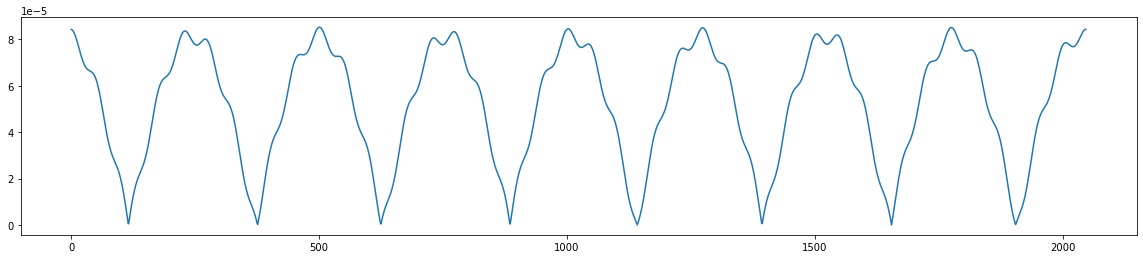

In [5]:
window_size = 2048
one_khz_examples = load_examples('/home/zond/DriveFileStream/My Drive/korvapuusti/listening_tests/modern_format/by_probe_center/1kHz/*/*.json').batch(512)
for ex in one_khz_examples.take(1):
    ex0 = ex
plt.figure(figsize=(20,4))
plt.plot(np.arange(window_size), np.abs(ex0[0][0,:window_size]))
plt.show()

In [6]:
assertequal(list(itertools.combinations(np.arange(5),4)), [[0, 1, 2, 3], [0, 1, 2, 4], [0, 1, 3, 4], [0, 2, 3, 4], [1, 2, 3, 4]])

In [7]:
assertequal(coeffs(tf.constant([
    (-0.05429768147702485+1.4172655611120915e-05j),
    (0.2917622403739163+0.7731812636894612j),
    (0.8768382244780407-0.31120458350060115j),
    (0.6598943546882394-0.46728573398560225j),
    (-0.05429768147702485-1.4172655611120915e-05j),
    (0.2917622403739163-0.7731812636894612j),
    (0.8768382244780407+0.31120458350060115j),
    (0.6598943546882394+0.46728573398560225j)])), tf.constant([
    (1+0j), 
    (-3.548394276126343+5.551115123125783e-17j), 
    (5.916185211745642-3.885780586188048e-16j), 
    (-5.950823836910118-2.7755575615628914e-17j), 
    (3.819250686844303+3.3306690738754696e-16j),
    (-1.4222617112159746+8.326672684688674e-17j), 
    (0.1942351079538039-6.938893903907228e-18j), 
    (0.03639413827830768-2.8189256484623115e-18j), 
    (0.0011396243277688343+1.0842021724855044e-19j)]))

In [8]:
ear_cell = PZCell(tf.cast(1.34, dtype=tf.complex128),
                 tf.constant([
                     (-0.05429768147702485+1.4172655611120915e-05j),
                     (0.2917622403739163+0.7731812636894612j),
                     (0.8768382244780407-0.31120458350060115j),
                     (0.6598943546882394-0.46728573398560225j)
                 ], dtype=tf.complex128),
                 tf.constant([
                     (0.635496172349615+0.14499945287904842j),
                     (0.30987058966944614-0.8574194617385421j),
                     (0.5721096307971768-2.2915816453724273e-05j)
                 ], dtype=tf.complex128))
ear_layer = RNNLayer(ear_cell)
impulse = np.zeros([3, 10, 1], dtype=np.float64)
impulse[:,0,:] = 1
got = ear_layer(impulse)
want_per_batch = [[[0.0], [0.0], [1.340000033378601], [0.6880116143997395], [0.5898482067084059], [0.26539000302780025], [-0.17838450178081278], [-0.535161973120797], [-0.6439493898291794], [-0.5374803112705164]]]
want = tf.constant(np.concatenate([want_per_batch, want_per_batch, want_per_batch], axis=0))
assertequal(got, want)

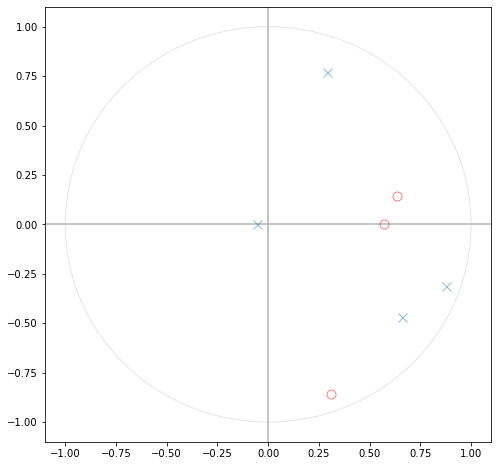

In [9]:
ear_cell = PZCell(tf.cast(1.34, dtype=tf.complex128),
                 tf.constant([
                     (-0.05429768147702485+1.4172655611120915e-05j),
                     (0.2917622403739163+0.7731812636894612j),
                     (0.8768382244780407-0.31120458350060115j),
                     (0.6598943546882394-0.46728573398560225j)
                 ], dtype=tf.complex128),
                 tf.constant([
                     (0.635496172349615+0.14499945287904842j),
                     (0.30987058966944614-0.8574194617385421j),
                     (0.5721096307971768-2.2915816453724273e-05j)
                 ], dtype=tf.complex128))
plot_pz(ear_cell)

1.333463430404663
0.5074155330657959


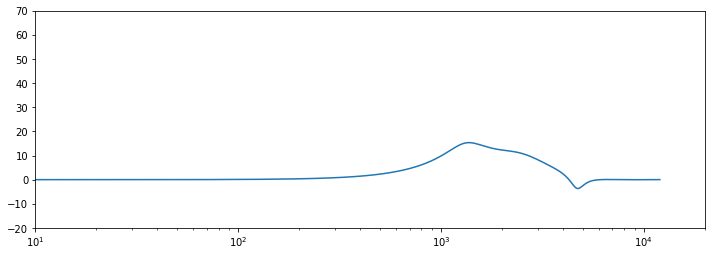

In [10]:
ear_cell = PZCell(tf.cast(1.34, dtype=tf.complex128),
                 tf.constant([
                     (-0.05429768147702485+1.4172655611120915e-05j),
                     (0.2917622403739163+0.7731812636894612j),
                     (0.8768382244780407-0.31120458350060115j),
                     (0.6598943546882394-0.46728573398560225j)
                 ], dtype=tf.complex128),
                 tf.constant([
                     (0.635496172349615+0.14499945287904842j),
                     (0.30987058966944614-0.8574194617385421j),
                     (0.5721096307971768-2.2915816453724273e-05j)
                 ], dtype=tf.complex128))
ear_layer = RNNLayer(ear_cell)
impulse = np.zeros([3, 2048, 1], dtype=np.float64)
impulse[:,0,:] = 1
t = time.time()
got = ear_layer(impulse)
print(time.time() - t)
t = time.time()
got = ear_layer(impulse)
print(time.time() - t)
plot_many_z(np.array([np.fft.fft(got[0,:,0])]))

3.108119487762451
0.9148600101470947


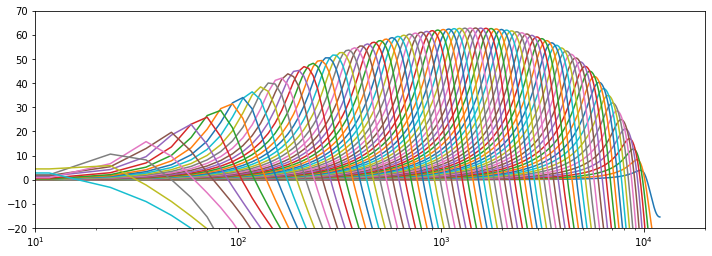

In [11]:
cc = CARCell(linear=True)
car_layer = RNNLayer(cc)
impulse = np.zeros([3, 2048, 1], dtype=np.float64)
impulse[:,0,:] = 1
impulse = tf.constant(impulse, name='impulse')
t = time.time()
got = car_layer(impulse)
print(time.time() - t)
t = time.time()
got = car_layer(impulse)
print(time.time() - t)
got = tf.transpose(got, [0,2,1])
plot_many_z(np.fft.fft(got[0]))

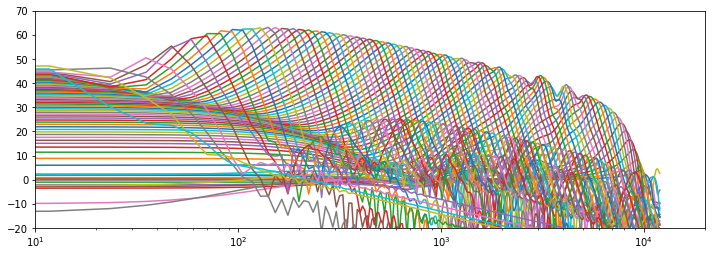

In [12]:
cc = CARCell(linear=False)
car_layer = RNNLayer(cc)
impulse = np.zeros([3, 2048, 1], dtype=np.float64)
impulse[:,0,:] = 1
impulse = tf.constant(impulse, name='impulse')
got = car_layer(impulse)
got = tf.transpose(got, [0,2,1])
plot_many_z(np.fft.fft(got[0]))

In [13]:
impulse = np.zeros([3, 32, 1], dtype=np.float64)
impulse[:,0, :] = 1
impulse = tf.constant(impulse)
ear_gain = tf.Variable(initial_value=1.34, dtype=tf.complex128)
ear_poles = tf.Variable(initial_value=[
                     (-0.05429768147702485+1.4172655611120915e-05j),
                     (0.2917622403739163+0.7731812636894612j),
                     (0.8768382244780407-0.31120458350060115j),
                     (0.6598943546882394-0.46728573398560225j)
                 ], dtype=tf.complex128)
ear_zeros = tf.Variable(initial_value=[
                     (0.635496172349615+0.14499945287904842j),
                     (0.30987058966944614-0.8574194617385421j),
                     (0.5721096307971768-2.2915816453724273e-05j)
                 ], dtype=tf.complex128)
ear_cell = PZCell(ear_gain, ear_poles, ear_zeros)
lpm = tf.keras.Sequential()
ear = RNNLayer(ear_cell)
lpm.add(ear)
cc = CARCell()
car = RNNLayer(cc)
lpm.add(car)
lpm.add(FFTLayer())
snr = SNRLayer()
lpm.add(snr)
lpl = LoudnessPredictorLayer()
lpm.add(lpl)
tape = tf.GradientTape()
with tape:
    res = lpm(impulse)
tape.gradient(res, [
    lpl._loudness_scale,
    lpl._loudness_offset,
    cc._high_f_damping_compression,
    cc._zero_ratio,
    cc._min_zeta,
    cc._erb_constant_0,
    cc._velocity_scale,
    cc._v_offset,
    ear_gain,
    ear_poles,
    ear_zeros
])

[<tf.Tensor: shape=(), dtype=float64, numpy=168.69126275633687>,
 <tf.Tensor: shape=(), dtype=float64, numpy=4800.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=491.57249983724046>,
 <tf.Tensor: shape=(), dtype=float64, numpy=5240.969981939406>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-7981.423951001873>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-9.283336641149557>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-7996.492674506834>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-435.537434780083>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(181.0876676439135-8.630188479858837e-14j)>,
 <tf.Tensor: shape=(4,), dtype=complex128, numpy=
 array([  78.35787035+2.46564268e-03j, -213.72268951-5.55696187e+02j,
        -181.00653229+4.76830219e+01j,  137.38513349-2.12530912e+02j])>,
 <tf.Tensor: shape=(3,), dtype=complex128, numpy=
 array([-28.53098048-1.12102145e+01j, 334.09425271-8.54400821e+02j,
        -37.29016474+1.39220836e-03j])>]

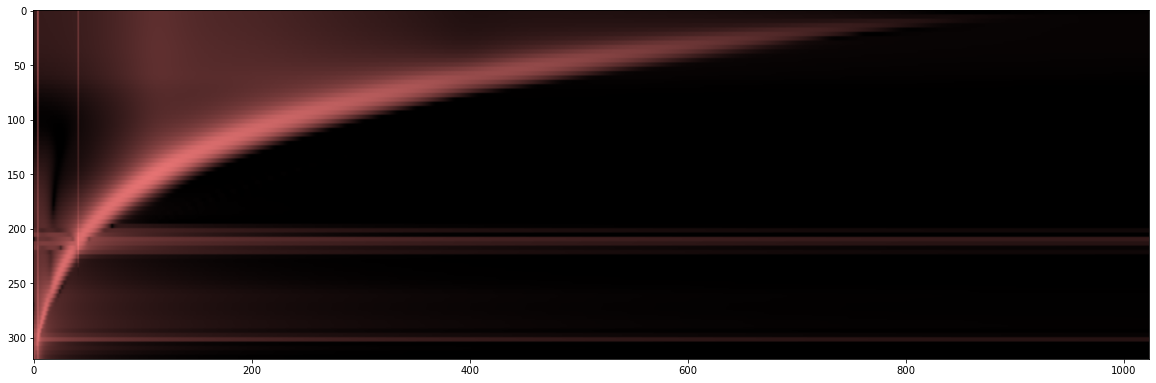

In [14]:
ear_gain = tf.Variable(initial_value=1.34, dtype=tf.complex128)
ear_poles = tf.Variable(initial_value=[
                     (-0.05429768147702485+1.4172655611120915e-05j),
                     (0.2917622403739163+0.7731812636894612j),
                     (0.8768382244780407-0.31120458350060115j),
                     (0.6598943546882394-0.46728573398560225j)
                 ], dtype=tf.complex128)
ear_zeros = tf.Variable(initial_value=[
                     (0.635496172349615+0.14499945287904842j),
                     (0.30987058966944614-0.8574194617385421j),
                     (0.5721096307971768-2.2915816453724273e-05j)
                 ], dtype=tf.complex128)
ear_cell = PZCell(ear_gain, ear_poles, ear_zeros)
lpm = tf.keras.Sequential()
ear = tf.keras.layers.RNN(ear_cell, return_sequences=True)
lpm.add(ear)
cc = CARCell()
car = tf.keras.layers.RNN(cc, return_sequences=True)
lpm.add(car)
lpm.add(tf.keras.layers.Permute((2,1)))
lpm.add(FFTLayer())
snr = SNRLayer()
lpm.add(snr)
got = lpm(ex0[0])
plot_snr(got[0])

0 418 418


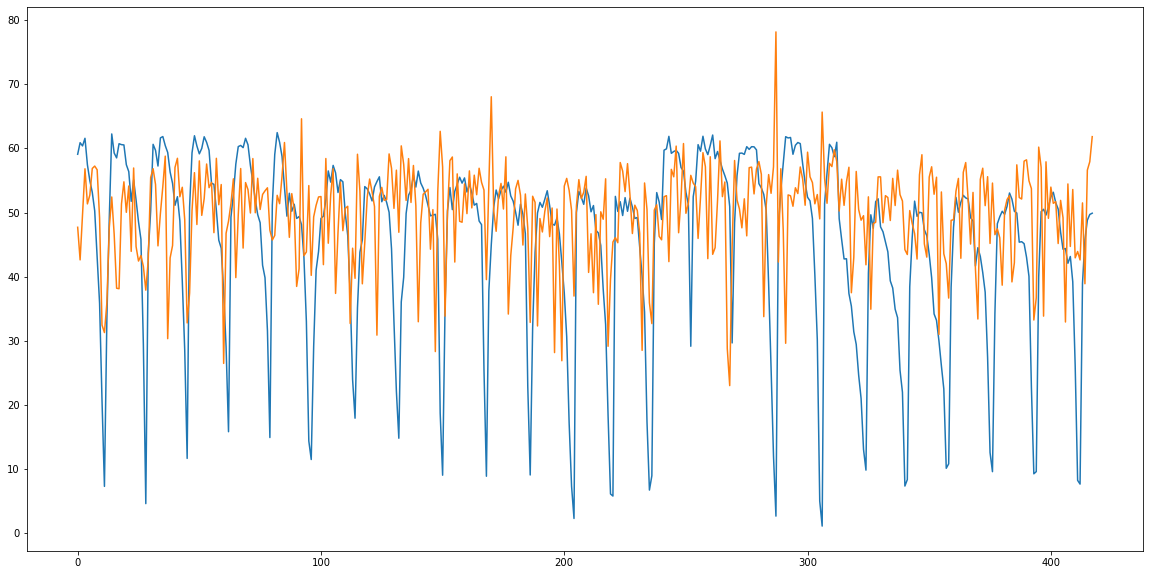

worst error at 291 64192.90965196739


In [15]:
ear_gain = tf.Variable(initial_value=1.34, dtype=tf.complex128)
ear_poles = tf.Variable(initial_value=[
                     (-0.05429768147702485+1.4172655611120915e-05j),
                     (0.2917622403739163+0.7731812636894612j),
                     (0.8768382244780407-0.31120458350060115j),
                     (0.6598943546882394-0.46728573398560225j)
                 ], dtype=tf.complex128)
ear_zeros = tf.Variable(initial_value=[
                     (0.635496172349615+0.14499945287904842j),
                     (0.30987058966944614-0.8574194617385421j),
                     (0.5721096307971768-2.2915816453724273e-05j)
                 ], dtype=tf.complex128)
ear_cell = PZCell(ear_gain, ear_poles, ear_zeros)
lpm = tf.keras.Sequential()
ear = tf.keras.layers.RNN(ear_cell, return_sequences=True)
lpm.add(ear)
cc = CARCell()
car = tf.keras.layers.RNN(cc, return_sequences=True)
lpm.add(car)
lpm.add(tf.keras.layers.Permute((2,1)))
lpm.add(FFTLayer())
snr = SNRLayer()
lpm.add(snr)
lpl = LoudnessPredictorLayer()
lpm.add(lpl)
(worst_index, worst_error, worst_example) = plot_pred(lpm, one_khz_examples)
print('worst error at', worst_index, worst_error)

In [ ]:
lpm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=LoudnessPredictorLoss())
while True:
    lpm.fit(one_khz_examples, epochs=10, verbose=2)
    plot_pred(lpm, one_khz_examples)

In [ ]:
plot_pred(lpm, one_khz_examples)